# Analisis exploratorio

### Links
- [SentenceTransformers](https://www.sbert.net/)
- [UMAP](https://umap-learn.readthedocs.io/en/latest)
- [Plotting UMAP results](https://umap-learn.readthedocs.io/en/latest/plotting.html)

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('../../src')

from matplotlib import pyplot as plt
import seaborn  as sns

import numpy  as np
import pandas as pd
import torch

import logging
import random

import data  as dt
import model as ml
import util  as ut
import pytorch_common.util as pu

## Setup

Se configura el default logger para que la consola sea el output y loguee mensajes a partir del nivel INFO.

In [5]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

Chequeamos si se detecta la GPU:

In [6]:
torch.cuda.is_available()

True

In [7]:
torch.__version__

'1.12.1+cu116'

Por defecto usamos GPU. De no existir este hardware, el fallback es CPU:

In [8]:
pu.set_device_name('gpu')

logging.info(pu.get_device())

2022-09-09 20:12:43,965 - INFO - cuda:0


In [9]:
torch.cuda.get_arch_list()

['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

Fijamos la semilla:

In [10]:
def set_seed(value):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)

In [11]:
set_seed(42)

Parametros de la notebook:

In [12]:
DATASET_PATH = '../../datasets-ebay'

### Funciones helper

In [13]:
def plot_categories(groups):
    plt.figure(figsize=(15,7))
    ax = sns.barplot(x=groups['category'], y='title', data=groups)
    ax.set(xlabel=None)
    ax.set(xticklabels=[])
    plt.show()

In [14]:
def append(hash_table, key, value):
    if key not in hash_table:
        hash_table[key] = []
    hash_table[key].append(value)

def branches_to_data_frame(df, column, separator='~'):
    count_df = dataset[column].value_counts()

    branches = [[v.strip() for v in value.split(separator)] for value in count_df.index]
    n_levels = max([len(b) for b in branches])
    
    data = {}
    for branch in branches:
        last_level = 0
        for level, value in enumerate(branch):
            last_level = level
            append(data, f'level_{level}', value)
        for level in range(last_level+1, n_levels+1):
            append(data, f'level_{level}', None)

    data['count'] = count_df.values.tolist()

    return pd.DataFrame(data)

## Preparar dataset

In [15]:
dataset = pd.read_csv(f'{DATASET_PATH}/ebay-all.csv')
dataset.head()

,title,category,category_seq
0,Mrs Sinclair's Suitcase: 'A heart-breaking tal...,"eBay ~ Books, Comics & Magazines ~ Books",0
1,Stone Mothers: The addictive new thriller from...,"eBay ~ Books, Comics & Magazines ~ Books",0
2,Don't Close Your Eyes: The astonishing psychol...,"eBay ~ Books, Comics & Magazines ~ Books",0
3,Regency Scandal: Dissolute Ways: The Runaway C...,"eBay ~ Books, Comics & Magazines ~ Books",0
4,Gone Without A Trace: a gripping psychological...,"eBay ~ Books, Comics & Magazines ~ Books",0


# Visualización de categorias de productos

<Figure size 1500x700 with 1 Axes>

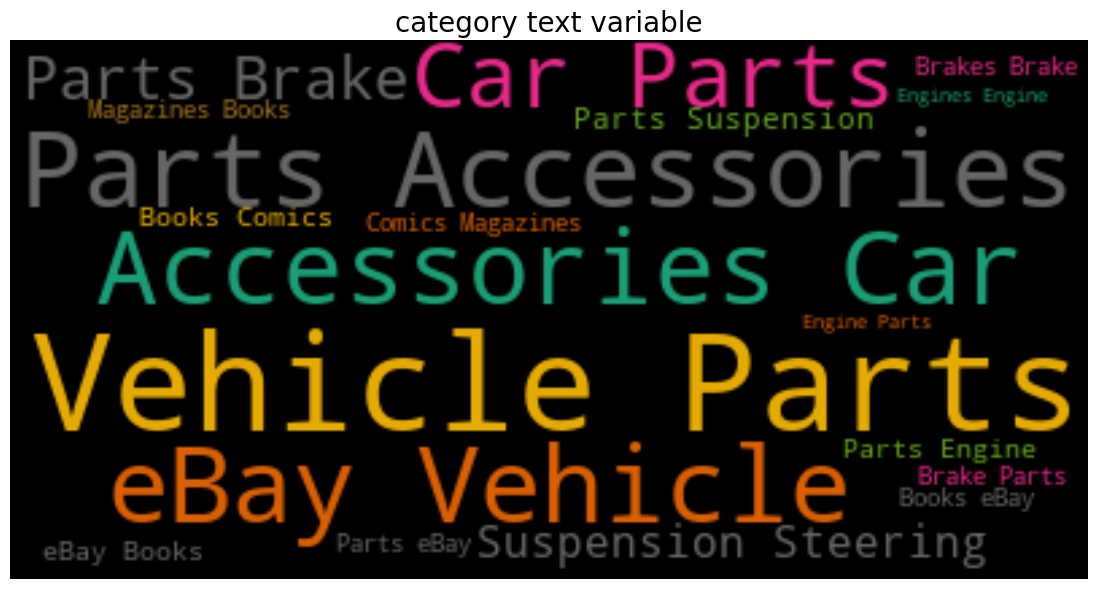

In [26]:
plt.figure(figsize=(15,7))

dataset['category'] = dataset['category'].apply(lambda x: ' '.join(x.split('~')))

dt.describe_text_var(dataset, 'category')

<Figure size 1500x700 with 1 Axes>

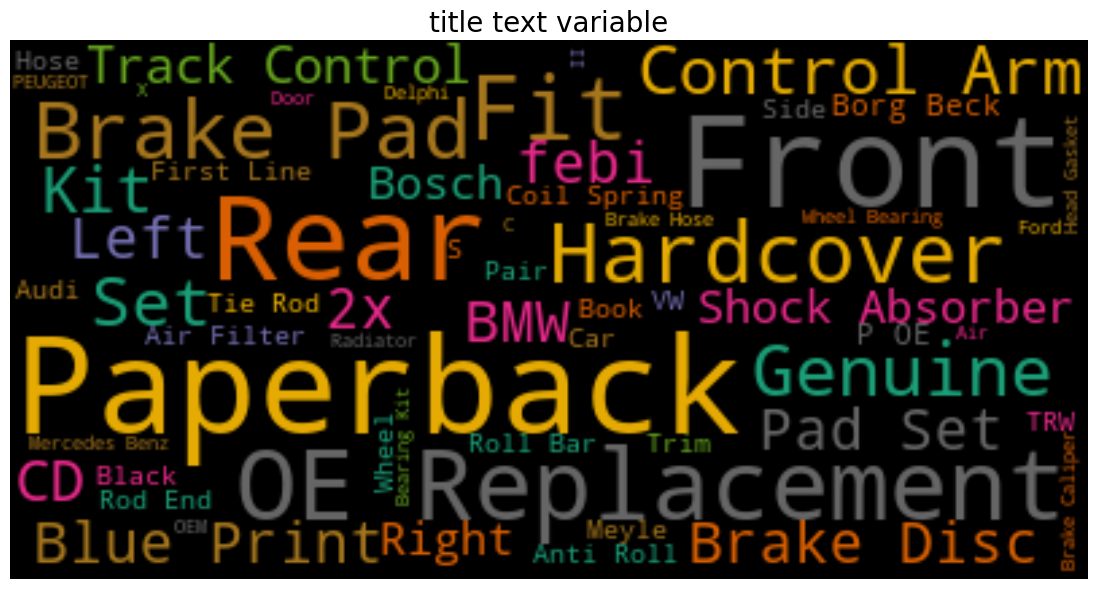

In [22]:
plt.figure(figsize=(15,7))
dt.describe_text_var(dataset, 'title')

La columna category representa la rama del arbol de categorias donde se encuentra un producto.

In [14]:
category_branches = dataset['category']
category_branches.head()

0    eBay ~ Books, Comics & Magazines ~ Books
1    eBay ~ Books, Comics & Magazines ~ Books
2    eBay ~ Books, Comics & Magazines ~ Books
3    eBay ~ Books, Comics & Magazines ~ Books
4    eBay ~ Books, Comics & Magazines ~ Books
Name: category, dtype: object

**Observaciones**

* Se peude apreciar que cada producto se encuetra dentro de una categoria hoja dentro del un arbolde categorias.
* A su vez pertenese a una categoria padre.
* El arbol de categoroas parece tener unicamente 3 niveles.

Creamos un data frame con todas las ramas/arista del arbol de categorias, Luiego graficamos la jerarquia de categorias, especificando la cantidad de productos por cada categoria:

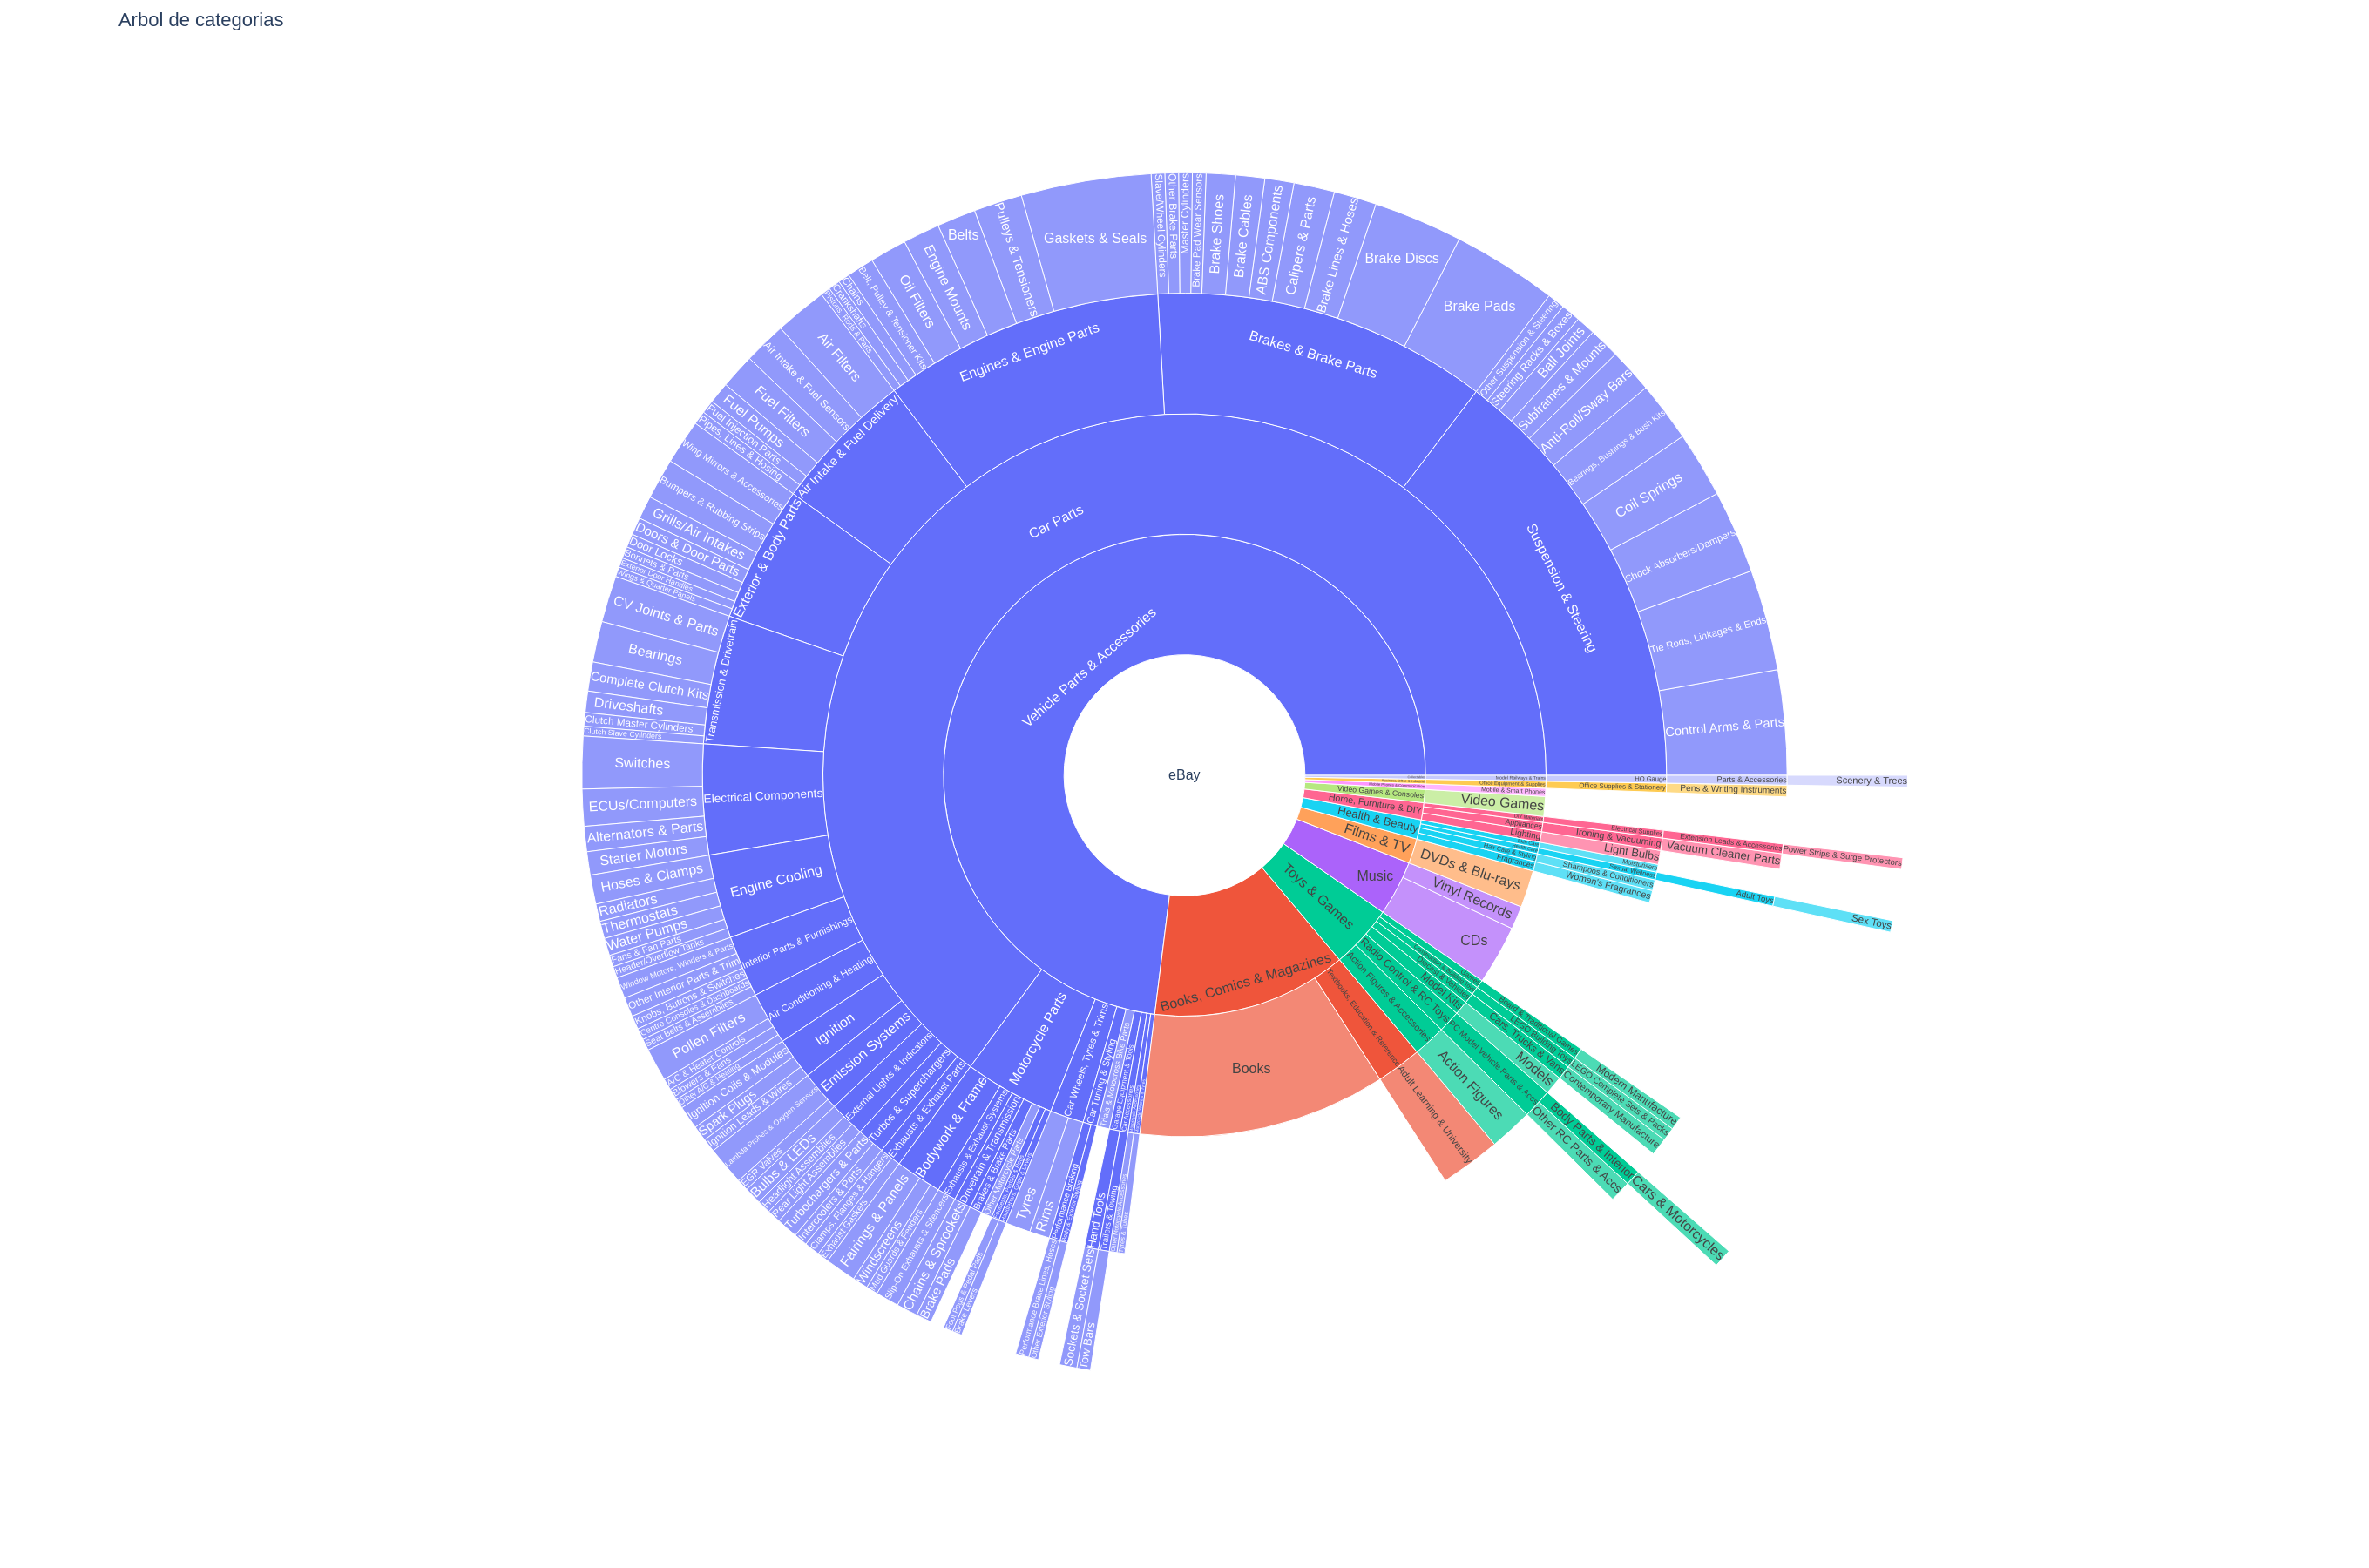

In [25]:
dt.plot_tree(
    df    = branches_to_data_frame(dataset, 'category'),
    title = "Arbol de categorias"
)

**Observaciones**

* Constatamos que existen 6 niveles incluida la raiz del arbol, la cual identifica al e-commerce.
* Vemos que el arbol esta muy desbalanceado. Es decir, existe una gran diferencia en numero de productos por cada categoria.
* Existen muchas categorias con pocos producto y otras con un gran numero.
* Los productos siempre se encuentra en las categorias hijas.

## Cantidad de productos por categoria

<Figure size 1080x504 with 1 Axes>

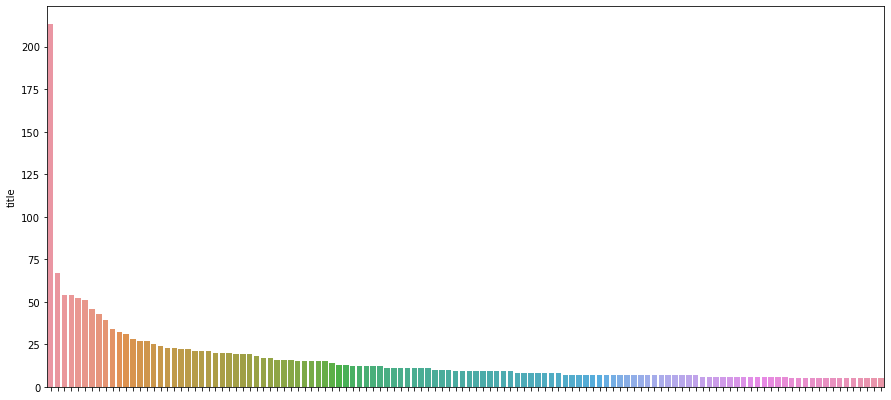

In [16]:
plot_categories(ut.group_by_count(dataset, ['category'], 'title'))

**Observaciones**

* Se aprecia que la variable **category** sigue una ley de potenticas. Es decir, existen pocas categorias que concentran la gran mayoria de productos, y luego muchas categorias que tiene muy pocos productos (Long tail).

## Cluster de categorias

A continacion se generan embeddings para cada categoria y título. Luego, se reduce la dimensionalidad de los embeddings para poder graficar su similitud en dos dimensiones:

In [19]:
sentence_encoder = ml.SentenceEncoder('all-MiniLM-L6-v2')

2022-09-04 20:55:14,137 - INFO - Load pretrained SentenceTransformer: all-MiniLM-L6-v2
2022-09-04 20:55:14,333 - INFO - Use pytorch device: cuda


In [20]:
categories = np.unique(dataset['category'])

category_embeddindgs = sentence_encoder(categories)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Opening in existing browser session.


[2248603:2248603:0100/000000.786445:ERROR:vaapi_wrapper.cc(1299)] vaQuerySurfaceAttributes failed, VA error: invalid parameter
[2248603:2248603:0100/000000.786475:ERROR:vaapi_wrapper.cc(1246)] FillProfileInfo_Locked failed for va_profile VAProfileH264Main and entrypoint VAEntrypointVLD
[2248603:2248603:0100/000000.786485:ERROR:vaapi_wrapper.cc(1299)] vaQuerySurfaceAttributes failed, VA error: invalid parameter
[2248603:2248603:0100/000000.786496:ERROR:vaapi_wrapper.cc(1246)] FillProfileInfo_Locked failed for va_profile VAProfileH264High and entrypoint VAEntrypointVLD


122

<Figure size 1000x1000 with 1 Axes>

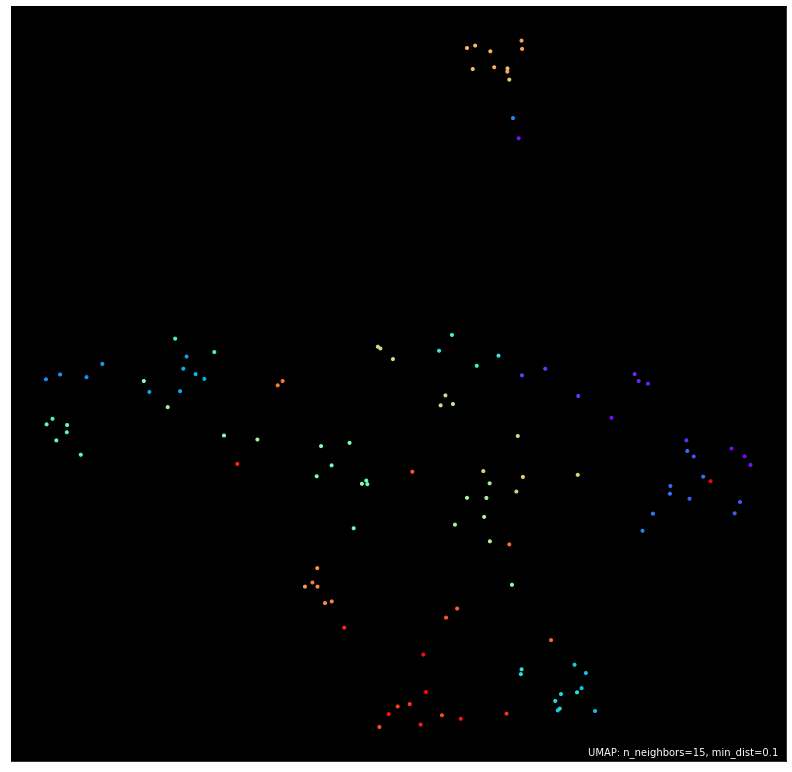

<Figure size 1000x1000 with 1 Axes>

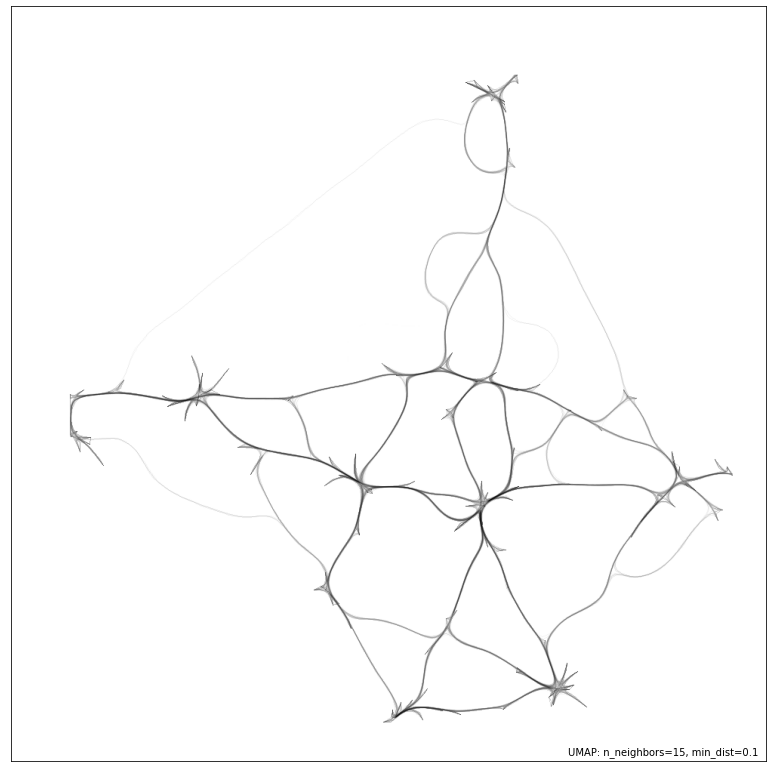

In [21]:
ml.UMAP(category_embeddindgs) \
    .plot_clusters(labels=categories) \
    .plot_interactive_clusters(labels=categories) \
    .plot_connectivity()

len(categories)

## Cluster de productos por similitud entre titulos

A continuación, se generan embeddings para cada título. Luego, se reduce la dimendionalidad para visualizar la distancia entre títulos deacuerdo a su similutud. Los colres representan las categorias a las que pertenece cada título/producto.

In [22]:
title_cat_df = dataset[['title', 'category']].drop_duplicates()

title_cat_df.shape

(1923, 2)

In [23]:
title_embeddindgs  = sentence_encoder(title_cat_df['title'].values)

Batches:   0%|          | 0/61 [00:00<?, ?it/s]

Opening in existing browser session.


[2250078:2250078:0100/000000.144603:ERROR:vaapi_wrapper.cc(1299)] vaQuerySurfaceAttributes failed, VA error: invalid parameter
[2250078:2250078:0100/000000.144631:ERROR:vaapi_wrapper.cc(1246)] FillProfileInfo_Locked failed for va_profile VAProfileH264Main and entrypoint VAEntrypointVLD
[2250078:2250078:0100/000000.144642:ERROR:vaapi_wrapper.cc(1299)] vaQuerySurfaceAttributes failed, VA error: invalid parameter
[2250078:2250078:0100/000000.144651:ERROR:vaapi_wrapper.cc(1246)] FillProfileInfo_Locked failed for va_profile VAProfileH264High and entrypoint VAEntrypointVLD


<model.umap.UMAP object at 0x7fa9b9133550>

<Figure size 1000x1000 with 1 Axes>

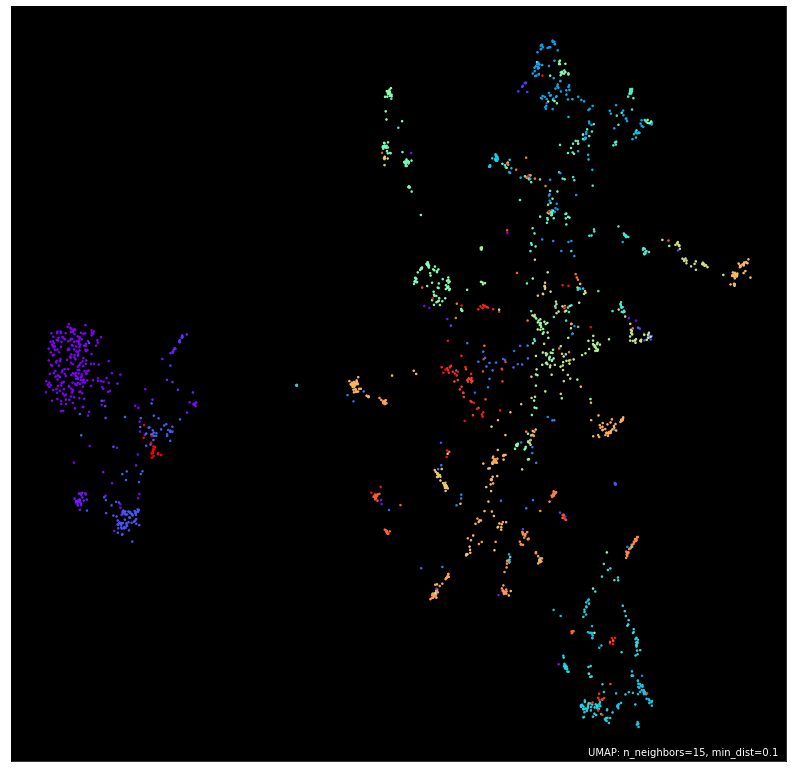

<Figure size 1000x1000 with 1 Axes>

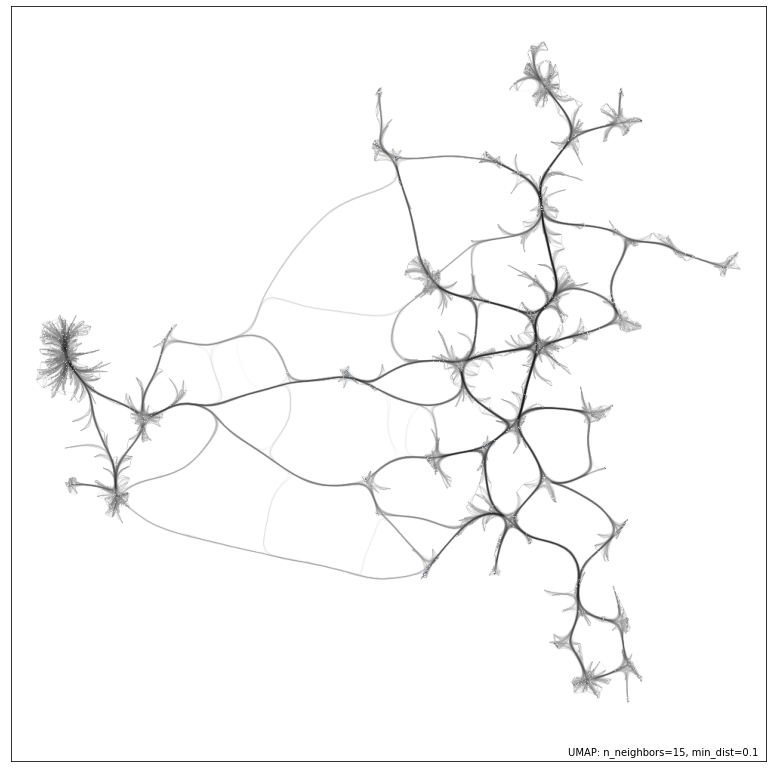

In [24]:
ml.UMAP(title_embeddindgs) \
    .plot_clusters(labels=title_cat_df['category']) \
    .plot_interactive_clusters(labels=title_cat_df['category']) \
    .plot_connectivity()